# LSTM PREDICTION

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import os

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error,r2_score
from tensorflow.keras.callbacks import TensorBoard

In [3]:
df = pd.read_csv(os.getcwd()+"/pre_processing/dataset_traite_minute_mean_na.csv", sep=',', parse_dates=["DateTime"])

In [12]:
timeframe = "3h"

df_lstm = df.set_index('DateTime')
df_lstm = df_lstm.resample(timeframe).mean()
df_lstm['Date'] = pd.to_datetime(df_lstm.index.date)
df_lstm.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Date
DateTime,,,,,,,,
2006-12-16 15:00:00,4.222889,0.229000,234.643889,18.100000,0.0,0.527778,16.861111,2006-12-16
2006-12-16 18:00:00,3.433667,0.080122,233.961389,14.673333,0.0,2.716667,16.777778,2006-12-16
2006-12-16 21:00:00,2.439400,0.068089,238.846111,10.488889,0.0,0.211111,7.216667,2006-12-16
2006-12-17 00:00:00,2.273044,0.105867,242.409611,9.747778,0.0,8.755556,0.000000,2006-12-17
2006-12-17 03:00:00,1.958233,0.077744,244.026389,8.368889,0.0,0.500000,4.511111,2006-12-17


In [13]:
temperatures = pd.read_csv("pre_processing/temperatures.csv", parse_dates=['Date'], index_col='Date')
temperatures['avg_t'] = (temperatures['max_t'] - temperatures['min_t'])/2
temperatures.head(2)

,min_t,max_t,avg_t
Date,,,
2006-01-02,3.0,7.6,2.30
2006-01-03,3.9,6.8,1.45


In [14]:
df_lstm = df_lstm.join(temperatures, how="left", on='Date')
df_lstm = df_lstm.drop(columns=['Date','avg_t', 'Voltage', 'Global_intensity'])
df_lstm.head(3)

,Global_active_power,Global_reactive_power,Sub_metering_1,Sub_metering_2,Sub_metering_3,min_t,max_t
DateTime,,,,,,,
2006-12-16 15:00:00,4.222889,0.229000,0.0,0.527778,16.861111,0.3,9.5
2006-12-16 18:00:00,3.433667,0.080122,0.0,2.716667,16.777778,0.3,9.5
2006-12-16 21:00:00,2.439400,0.068089,0.0,0.211111,7.216667,0.3,9.5


In [15]:
df_lstm["Hour"] = df_lstm.index.hour + df_lstm.index.minute/60
df_lstm["Day"] = df_lstm.index.dayofweek
df_lstm["Month"] = df_lstm.index.month
df_lstm.head(3)

,Global_active_power,Global_reactive_power,Sub_metering_1,Sub_metering_2,Sub_metering_3,min_t,max_t,Hour,Day,Month
DateTime,,,,,,,,,,
2006-12-16 15:00:00,4.222889,0.229000,0.0,0.527778,16.861111,0.3,9.5,15.0,5,12
2006-12-16 18:00:00,3.433667,0.080122,0.0,2.716667,16.777778,0.3,9.5,18.0,5,12
2006-12-16 21:00:00,2.439400,0.068089,0.0,0.211111,7.216667,0.3,9.5,21.0,5,12


In [16]:
# Check if there are any NaNs in the data
print(df_lstm.isnull().sum())

Global_active_power      0
Global_reactive_power    0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
min_t                    0
max_t                    0
Hour                     0
Day                      0
Month                    0
dtype: int64


In [17]:
scaler = MinMaxScaler(feature_range=(-1,1))
df_lstm[df_lstm.columns] = scaler.fit_transform(df_lstm)
df_lstm.describe()

,Global_active_power,Global_reactive_power,Sub_metering_1,Sub_metering_2,Sub_metering_3,min_t,max_t,Hour,Day,Month
count,11531.000000,11531.000000,11531.000000,11531.000000,11531.000000,11531.000000,11531.000000,11531.000000,11531.000000,11531.000000
mean,-0.652902,-0.581935,-0.913692,-0.922883,-0.352936,0.141051,0.021381,0.000186,-0.000289,-0.008885
std,0.287086,0.179776,0.196272,0.188236,0.611017,0.361468,0.379395,0.654709,0.666696,0.621130
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-0.902554,-0.702033,-1.000000,-0.986801,-0.873678,-0.117460,-0.258228,-0.428571,-0.666667,-0.636364
50%,-0.711277,-0.624265,-1.000000,-0.980201,-0.544797,0.155556,0.032911,0.142857,0.000000,-0.090909
75%,-0.472789,-0.521939,-0.997007,-0.968652,0.106566,0.441270,0.316456,0.714286,0.666667,0.454545
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [18]:
# timeframe = "h"

# df_lstm = df.set_index('DateTime')
# df_lstm = df_lstm.resample(timeframe).mean()
# df_lstm['Date'] = pd.to_datetime(df_lstm.index.date)
# temperatures = pd.read_csv("pre_processing/temperatures.csv", parse_dates=['Date'], index_col='Date')
# temperatures['avg_t'] = (temperatures['max_t'] - temperatures['min_t'])/2
# df_lstm = df_lstm.join(temperatures, how="left", on='Date')
# df_lstm = df_lstm.drop(columns=['Date','max_t','min_t'])
# #df_lstm["Day"] = df_lstm.index.dayofweek+1
# #y = pd.get_dummies(df_lstm.Day, prefix='Day')
# #df_lstm = df_lstm.join(y, how="left")
# #df_lstm = df_lstm.drop(columns=["Day"])
# df_lstm = df_lstm.drop(columns=["Global_reactive_power"])
# df_lstm.head()

In [19]:
def data_to_supervised(df, col_to_predict="Global_active_power"):
    data = pd.DataFrame(df)
    columns = []
    columns.append(data.shift(1))
    columns.append(data.shift(0)[col_to_predict])
    df_labeled = pd.concat(columns, axis=1)
    names = [col + "(t-1)" for col in df.columns]
    names.append(f"{col_to_predict}(t)")
    df_labeled.columns = names
    df_labeled.dropna(inplace=True)
    
    return df_labeled

In [20]:
df_lstm = data_to_supervised(df_lstm)
df_lstm.head(5)

,Global_active_power(t-1),Global_reactive_power(t-1),Sub_metering_1(t-1),Sub_metering_2(t-1),Sub_metering_3(t-1),min_t(t-1),max_t(t-1),Hour(t-1),Day(t-1),Month(t-1),Global_active_power(t)
DateTime,,,,,,,,,,,
2006-12-16 18:00:00,0.511114,-0.226075,-1.0,-0.968652,0.688926,-0.415873,-0.321519,0.428571,0.666667,1.0,0.217720
2006-12-16 21:00:00,0.217720,-0.729220,-1.0,-0.838640,0.680579,-0.415873,-0.321519,0.714286,0.666667,1.0,-0.151900
2006-12-17 00:00:00,-0.151900,-0.769888,-1.0,-0.987461,-0.277129,-0.415873,-0.321519,1.000000,0.666667,1.0,-0.213742
2006-12-17 03:00:00,-0.213742,-0.642215,-1.0,-0.479954,-1.000000,-0.193651,-0.367089,-1.000000,1.000000,1.0,-0.330774
2006-12-17 06:00:00,-0.330774,-0.737256,-1.0,-0.970302,-0.548136,-0.193651,-0.367089,-0.714286,1.000000,1.0,-0.462225


In [33]:
values = df_lstm.values

trainsize = 0.8
n_rows = round(len(values)*trainsize)
print(f"Taille du trainset : {n_rows}")

train = values[:n_rows, :]
test = values[n_rows:, :]

train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D format as expected by LSTMs [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

Taille du trainset : 9224
(9224, 1, 10) (9224,) (2306, 1, 10) (2306,)


In [22]:
model = Sequential()
#recurrent_activation ='selu' # 1er place
#recurrent_activation ='softsign' # 2e place

model.add(LSTM(125, input_shape=(train_X.shape[1], train_X.shape[2]),recurrent_activation ='sigmoid',activation='tanh',return_sequences=False))
#model.add(LSTM(2*24,recurrent_activation ='sigmoid',activation='tanh',return_sequences=True))
#model.add(LSTM(2*24,recurrent_activation ='sigmoid',activation='tanh'))
#model.add(Dropout(0.2))
model.add(Dense(1))
#model.compile(loss='mean_squared_error', optimizer='adam')

model.compile(loss='mean_absolute_error', optimizer='adam')
#model.compile(optimizer=tensorflow.keras.optimizers.SGD(learning_rate=0.001),
             # loss=tensorflow.keras.losses.MeanSquaredError(),
             # metrics=['mse'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 125)               68000     
                                                                 
 dense (Dense)               (None, 1)                 126       
                                                                 
Total params: 68,126
Trainable params: 68,126
Non-trainable params: 0
_________________________________________________________________


In [47]:
# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=25, validation_data=(test_X, test_y), verbose=1, shuffle=False)

Epoch 1/100
369/369 [==============================] - 1s 2ms/step - loss: 0.1755 - val_loss: 0.1498
Epoch 2/100
369/369 [==============================] - 1s 2ms/step - loss: 0.1754 - val_loss: 0.1468
Epoch 3/100
369/369 [==============================] - 1s 2ms/step - loss: 0.1747 - val_loss: 0.1462
Epoch 4/100
369/369 [==============================] - 1s 2ms/step - loss: 0.1746 - val_loss: 0.1452
Epoch 5/100
369/369 [==============================] - 1s 2ms/step - loss: 0.1741 - val_loss: 0.1451
Epoch 6/100
369/369 [==============================] - 1s 2ms/step - loss: 0.1738 - val_loss: 0.1453
Epoch 7/100
369/369 [==============================] - 1s 3ms/step - loss: 0.1734 - val_loss: 0.1443
Epoch 8/100
369/369 [==============================] - 1s 2ms/step - loss: 0.1729 - val_loss: 0.1438
Epoch 9/100
369/369 [==============================] - 1s 2ms/step - loss: 0.1725 - val_loss: 0.1439
Epoch 10/100
369/369 [==============================] - 1s 2ms/step - loss: 0.1720 - val_lo

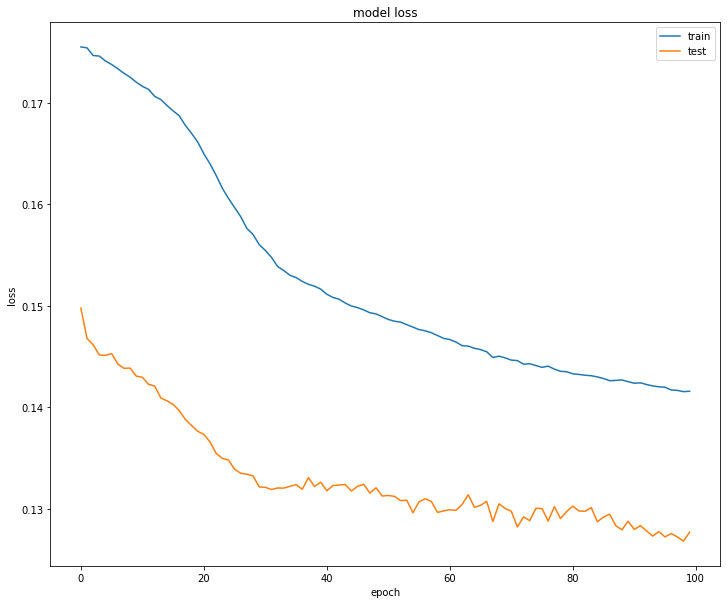

In [48]:
plt.figure(figsize=(12,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [49]:
test_X_temp = test_X.copy()
test_y_temp = test_y.copy()

size = df_lstm.shape[1]-1
# make a prediction
yhat = model.predict(test_X_temp)
test_X_temp = test_X_temp.reshape((test_X_temp.shape[0], size))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X_temp[:, 1-size:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y_temp = test_y_temp.reshape((len(test_y_temp), 1))
inv_y = np.concatenate((test_y_temp, test_X_temp[:, 1-size:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.465


In [50]:
import sklearn
r2 = sklearn.metrics.r2_score(inv_y, inv_yhat)
print(r2)
r_adjusted = 1 - ( 1-r2 ) * ( len(test_y) - 1 ) / ( len(test_y) - test_X.shape[1] - 1 )
print(r_adjusted)

0.4248713139846805
0.4246216921591529


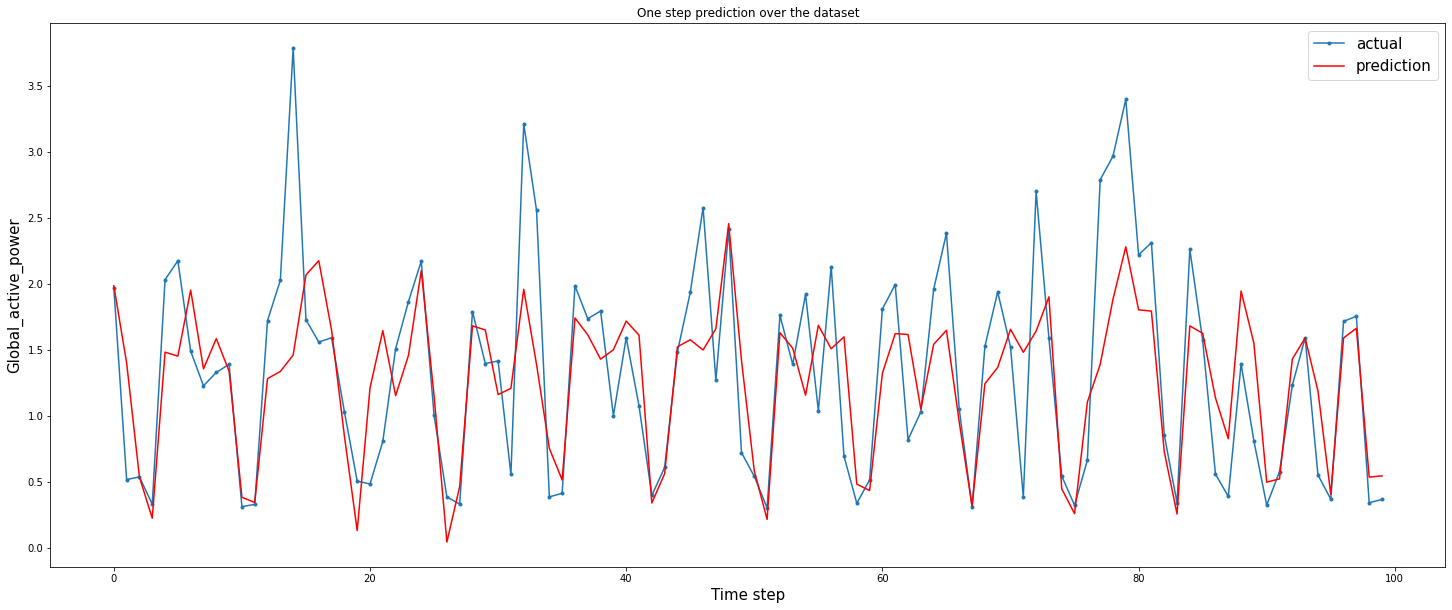

In [53]:
nbr_steps = 100
aa=[x for x in range(nbr_steps)]
plt.figure(figsize=(25,10))
plt.title("One step prediction over the dataset")
plt.plot(aa, inv_y[:nbr_steps], marker='.', label="actual")
plt.plot(aa, inv_yhat[:nbr_steps], 'r', label="prediction")
plt.ylabel(df.columns[1], size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()

# LSTM by Day

In [37]:
df_lstm = df.set_index('DateTime')
df_lstm = df_lstm.resample('h').mean()
df_lstm['Date'] = pd.to_datetime(df_lstm.index.date)
temperatures = pd.read_csv("pre_processing/temperatures.csv", parse_dates=['Date'], index_col='Date')
temperatures['avg_t'] = (temperatures['max_t'] - temperatures['min_t'])/2
df_lstm = df_lstm.join(temperatures, how="left", on='Date')
df_lstm = df_lstm.drop(columns=['Date','max_t','min_t'])
#df_lstm["Day"] = df_lstm.index.dayofweek+1
#y = pd.get_dummies(df_lstm.Day, prefix='Day')
#df_lstm = df_lstm.join(y, how="left")
#df_lstm = df_lstm.drop(columns=["Day"])
df_lstm = df_lstm.drop(columns=["Global_reactive_power"])
df_lstm2 = df_lstm.resample('d').mean()
df_lstm2.head(5)

,Global_active_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,avg_t
DateTime,,,,,,,
2006-12-16,3.120298,236.152341,13.369524,0.000000,1.330159,12.692063,4.60
2006-12-17,2.354486,240.087028,9.999028,1.411806,2.907639,9.264583,2.40
2006-12-18,1.530435,241.231694,6.421667,0.738194,1.820139,9.734722,3.40
2006-12-19,1.157079,241.999313,4.926389,0.582639,5.279167,4.303472,1.25
2006-12-20,1.545658,242.308063,6.467361,0.000000,1.838889,9.765972,2.35


In [38]:
scaler2 = MinMaxScaler(feature_range=(-1,1))
df_lstm2[df_lstm2.columns] = scaler2.fit_transform(df_lstm2[df_lstm2.columns])
df_lstm2.describe()

,Global_active_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,avg_t
count,1442.000000,1442.000000,1442.000000,1442.000000,1442.000000,1442.000000,1442.000000
mean,-0.415015,0.192762,-0.421554,-0.711249,-0.691183,-0.285828,-0.206912
std,0.265468,0.247181,0.261270,0.282645,0.343899,0.326069,0.390053
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-0.583958,0.103188,-0.589880,-0.873830,-0.928566,-0.513293,-0.502959
50%,-0.419776,0.207080,-0.429419,-0.799094,-0.881989,-0.286225,-0.242604
75%,-0.273436,0.317815,-0.285779,-0.605388,-0.551395,-0.071254,0.076923
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [39]:
df_lstm2 = data_to_supervised(df_lstm2)
df_lstm2.head(3)

['Global_active_power(t-1)', 'Voltage(t-1)', 'Global_intensity(t-1)', 'Sub_metering_1(t-1)', 'Sub_metering_2(t-1)', 'Sub_metering_3(t-1)', 'avg_t(t-1)', 'Global_active_power(t)']


,Global_active_power(t-1),Voltage(t-1),Global_intensity(t-1),Sub_metering_1(t-1),Sub_metering_2(t-1),Sub_metering_3(t-1),avg_t(t-1),Global_active_power(t)
DateTime,,,,,,,,
2006-12-17,0.876122,-0.380415,0.900371,-1.000000,-0.683636,0.513121,0.029586,0.388504
2006-12-18,0.388504,0.100987,0.390452,-0.636293,-0.308448,0.073525,-0.491124,-0.136197
2006-12-19,-0.136197,0.241035,-0.150764,-0.809828,-0.567099,0.133823,-0.254438,-0.373925


In [40]:
values = df_lstm2.values

trainsize = 0.8
n_rows = round(len(values)*trainsize)
print(f"Taille du trainset : {n_rows}")

train = values[:n_rows, :]
test = values[n_rows:, :]

train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D format as expected by LSTMs [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

Taille du trainset : 1153
(1153, 1, 7) (1153,) (288, 1, 7) (288,)


In [41]:
model = Sequential()
model.add(LSTM(7, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 7)                 420       
                                                                 
 dense_3 (Dense)             (None, 1)                 8         
                                                                 
Total params: 428
Trainable params: 428
Non-trainable params: 0
_________________________________________________________________


In [36]:
history = model.fit(train_X, train_y, epochs=75, batch_size=1, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Epoch 1/75
1153/1153 - 3s - loss: 0.0519 - val_loss: 0.0395 - 3s/epoch - 2ms/step
Epoch 2/75
1153/1153 - 1s - loss: 0.0437 - val_loss: 0.0382 - 1s/epoch - 1ms/step
Epoch 3/75
1153/1153 - 1s - loss: 0.0429 - val_loss: 0.0382 - 1s/epoch - 1ms/step
Epoch 4/75
1153/1153 - 1s - loss: 0.0423 - val_loss: 0.0381 - 1s/epoch - 1ms/step
Epoch 5/75
1153/1153 - 1s - loss: 0.0419 - val_loss: 0.0379 - 1s/epoch - 1ms/step
Epoch 6/75
1153/1153 - 1s - loss: 0.0416 - val_loss: 0.0377 - 1s/epoch - 1ms/step
Epoch 7/75
1153/1153 - 1s - loss: 0.0413 - val_loss: 0.0374 - 1s/epoch - 1ms/step
Epoch 8/75
1153/1153 - 1s - loss: 0.0411 - val_loss: 0.0371 - 1s/epoch - 1ms/step
Epoch 9/75
1153/1153 - 1s - loss: 0.0409 - val_loss: 0.0368 - 1s/epoch - 1ms/step
Epoch 10/75
1153/1153 - 1s - loss: 0.0408 - val_loss: 0.0365 - 1s/epoch - 1ms/step
Epoch 11/75
1153/1153 - 1s - loss: 0.0407 - val_loss: 0.0361 - 1s/epoch - 1ms/step
Epoch 12/75
1153/1153 - 1s - loss: 0.0405 - val_loss: 0.0358 - 1s/epoch - 1ms/step
Epoch 13/75
1

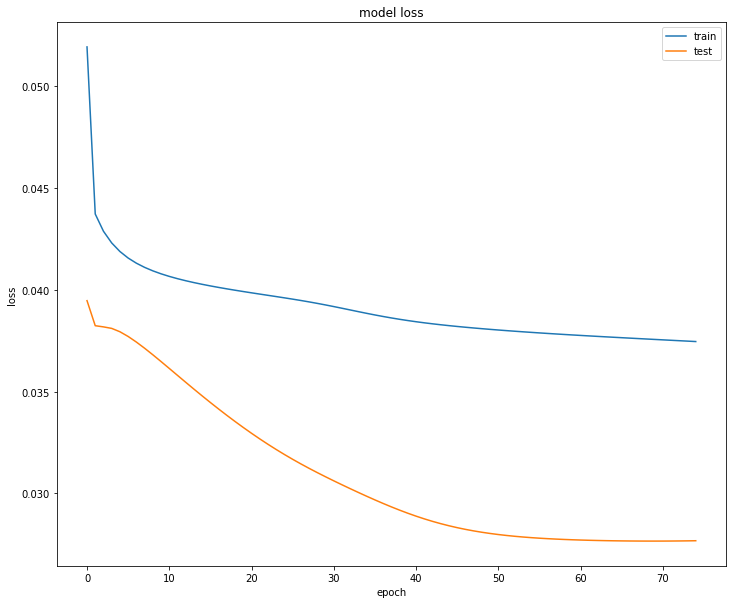

In [43]:
plt.figure(figsize=(12,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()
size = df_lstm2.shape[1]-1
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], size))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 1-size:]), axis=1)
inv_yhat = scaler2.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1-size:]), axis=1)
inv_y = scaler2.inverse_transform(inv_y)
inv_y = inv_y[:,0]

In [44]:
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.953


In [45]:
import sklearn
r2 = sklearn.metrics.r2_score(inv_y, inv_yhat)
print(r2)
r_adjusted = 1 - ( 1-r2 ) * ( len(test_y) - 1 ) / ( len(test_y) - test_X.shape[1] - 1 )
print(r_adjusted)

-9.073095593123314
-9.324922982951398


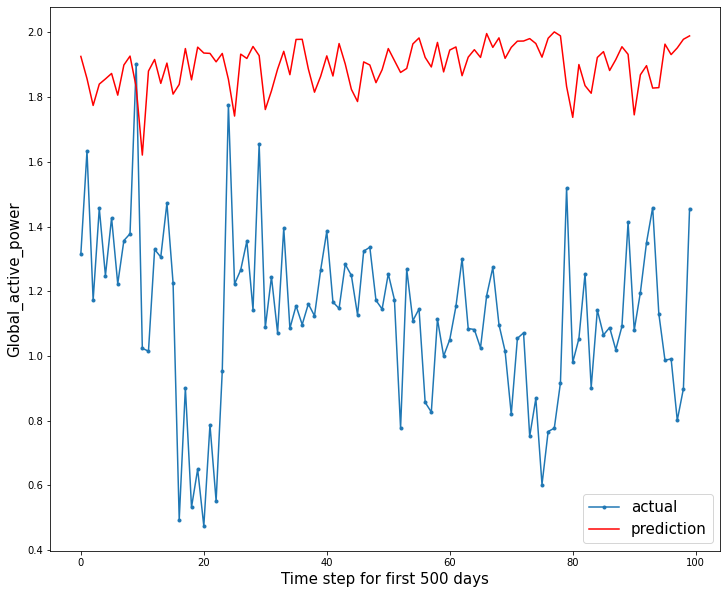

In [46]:
aa=[x for x in range(100)]
plt.figure(figsize=(12,10))
plt.plot(aa, inv_y[:100], marker='.', label="actual")
plt.plot(aa, inv_yhat[:100], 'r', label="prediction")
plt.ylabel(df.columns[1], size=15)
plt.xlabel('Time step for first 500 days', size=15)
plt.legend(fontsize=15)
plt.show()

# LSTM by minute

In [47]:
df_lstm = df.set_index('DateTime')
# df_lstm = df_lstm.resample('h').mean()
df_lstm['Date'] = pd.to_datetime(df_lstm.index.date)
temperatures = pd.read_csv("pre_processing/temperatures.csv", parse_dates=['Date'], index_col='Date')
temperatures['avg_t'] = (temperatures['max_t'] - temperatures['min_t'])/2
df_lstm = df_lstm.join(temperatures, how="left", on='Date')
df_lstm = df_lstm.drop(columns=['Date','max_t','min_t'])
#df_lstm["Day"] = df_lstm.index.dayofweek+1
#y = pd.get_dummies(df_lstm.Day, prefix='Day')
#df_lstm = df_lstm.join(y, how="left")
#df_lstm = df_lstm.drop(columns=["Day"])
df_lstm = df_lstm.drop(columns=["Global_reactive_power"])
# df_lstm2 = df_lstm.resample('d').mean()
# df_lstm2.head(5)

In [48]:
scaler = MinMaxScaler(feature_range=(-1,1))
df_lstm[df_lstm.columns] = scaler.fit_transform(df_lstm[df_lstm.columns])
df_lstm.describe()

,Global_active_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,avg_t
count,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06
mean,-8.161299e-01,1.398757e-01,-8.162930e-01,-9.745122e-01,-9.675372e-01,-5.832460e-01,-2.069884e-01
std,1.904368e-01,2.082981e-01,1.834536e-01,1.389810e-01,1.446527e-01,5.415017e-01,3.899690e-01
min,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00
25%,-9.576317e-01,2.164782e-02,-9.502075e-01,-1.000000e+00,-1.000000e+00,-1.000000e+00,-5.029586e-01
50%,-9.022271e-01,1.502423e-01,-8.921162e-01,-1.000000e+00,-1.000000e+00,-9.354839e-01,-2.426036e-01
75%,-7.374615e-01,2.704362e-01,-7.427386e-01,-1.000000e+00,-9.750000e-01,9.677419e-02,7.692308e-02
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [49]:
df_lstm = data_to_supervised(df_lstm)
df_lstm.head(3)

['Global_active_power(t-1)', 'Voltage(t-1)', 'Global_intensity(t-1)', 'Sub_metering_1(t-1)', 'Sub_metering_2(t-1)', 'Sub_metering_3(t-1)', 'avg_t(t-1)', 'Global_active_power(t)']


,Global_active_power(t-1),Voltage(t-1),Global_intensity(t-1),Sub_metering_1(t-1),Sub_metering_2(t-1),Sub_metering_3(t-1),avg_t(t-1),Global_active_power(t)
DateTime,,,,,,,,
2006-12-16 17:25:00,-0.250407,-0.247819,-0.244813,-1.0,-0.975,0.096774,0.029586,-0.043274
2006-12-16 17:26:00,-0.043274,-0.326010,-0.053942,-1.0,-0.975,0.032258,0.029586,-0.040739
2006-12-16 17:27:00,-0.040739,-0.347981,-0.053942,-1.0,-0.950,0.096774,0.029586,-0.038204


In [50]:
values = df_lstm.values

trainsize = 0.80
n_rows = round(len(values)*trainsize)
print(f"Taille du trainset : {n_rows}")

train = values[:n_rows, :]
test = values[n_rows:, :]

train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D format as expected by LSTMs [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

Taille du trainset : 1660206
(1660206, 1, 7) (1660206,) (415052, 1, 7) (415052,)


In [51]:
model = Sequential()
model.add(LSTM(3*60, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 180)               135360    
                                                                 
 dense_4 (Dense)             (None, 1)                 181       
                                                                 
Total params: 135,541
Trainable params: 135,541
Non-trainable params: 0
_________________________________________________________________


In [52]:
history = model.fit(train_X, train_y, epochs=5, batch_size=100, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Epoch 1/5
16603/16603 - 50s - loss: 0.0031 - val_loss: 0.0022 - 50s/epoch - 3ms/step
Epoch 2/5
16603/16603 - 48s - loss: 0.0027 - val_loss: 0.0016 - 48s/epoch - 3ms/step
Epoch 3/5
16603/16603 - 48s - loss: 0.0025 - val_loss: 0.0016 - 48s/epoch - 3ms/step
Epoch 4/5
16603/16603 - 48s - loss: 0.0025 - val_loss: 0.0015 - 48s/epoch - 3ms/step
Epoch 5/5
16603/16603 - 48s - loss: 0.0025 - val_loss: 0.0015 - 48s/epoch - 3ms/step


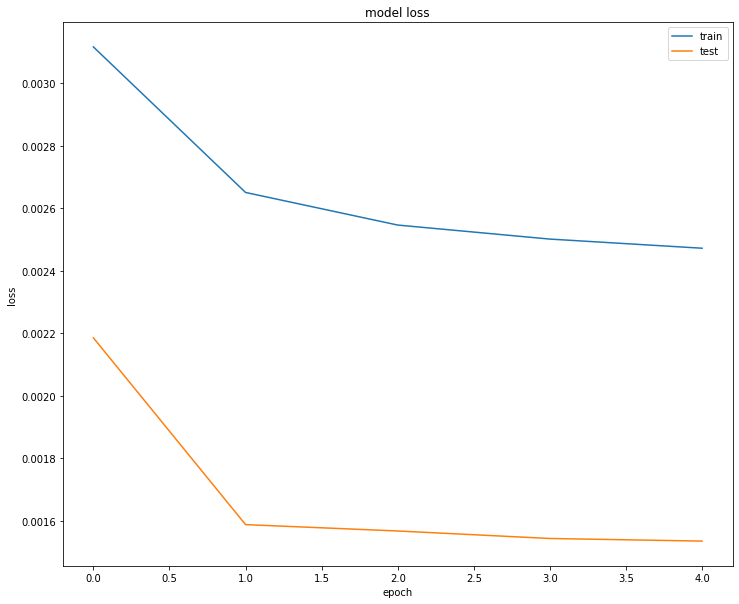

In [53]:
plt.figure(figsize=(12,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [54]:
size = df_lstm.shape[1]-1
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], size))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 1-size:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1-size:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

In [55]:
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.216


In [56]:
import sklearn
r2 = sklearn.metrics.r2_score(inv_y, inv_yhat)
print(r2)
r_adjusted = 1 - ( 1-r2 ) * ( len(test_y) - 1 ) / ( len(test_y) - test_X.shape[1] - 1 )
print(r_adjusted)

0.9390695180301031
0.9390684903959877


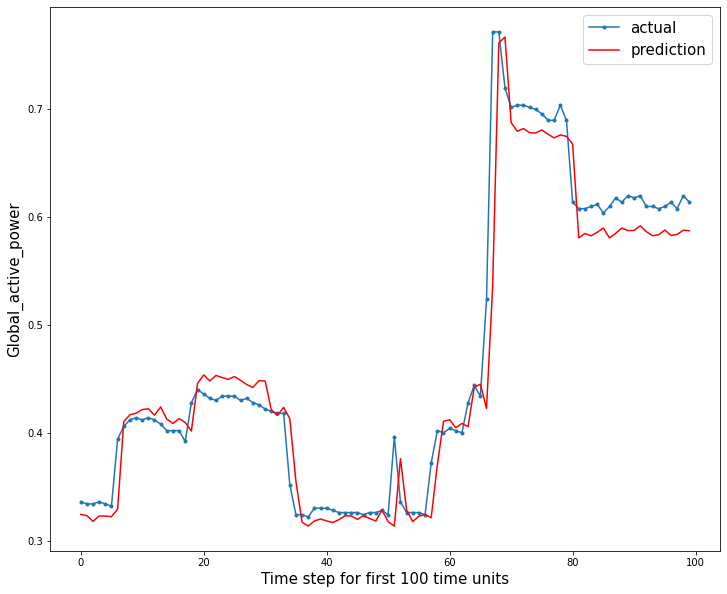

In [57]:
nbr_step = 100
aa=[x for x in range(nbr_step)]
plt.figure(figsize=(12,10))
plt.plot(aa, inv_y[:nbr_step], marker='.', label="actual")
plt.plot(aa, inv_yhat[:nbr_step], 'r', label="prediction")
plt.ylabel(df.columns[1], size=15)
plt.xlabel(f'Time step for first {nbr_step} time units', size=15)
plt.legend(fontsize=15)
plt.show()